# Import libraries

In [127]:
# -- coding:utf-8 --
import pandas as pd
import numpy as np
import os
import json
from os.path import join as pjoin

# from utils import is_number


from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import xgboost as xgb
from xgboost import plot_tree
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D
#import utils
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl

def show_confusion_matrix(validations, predictions):
        LABELS = ['Survival','Death']
        matrix = metrics.confusion_matrix(validations, predictions)
        # plt.figure(dpi=400,figsize=(4.5, 3))
        plt.figure(figsize=(4.5, 3))
        sns.heatmap(matrix,
                    cmap='coolwarm',
                    linecolor='white',
                    linewidths=1,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Global variables

In [128]:
# Common parameters
top3_feats_cols = ['LDH', 'CRP', 'lymph']
in_out_time_cols = ['Admission time', 'Discharge time']
train_excel_path = 'time_series_375_prerpocess_en.xlsx'  
#test_excel_path = 'time_series_test_110_preprocess_en.xlsx'
test_excel_path = 'covid.xlsx'
csv_output_path = '/content/predictions.csv'
test_json_path = '/content/Sheet1.json'

# Data Preprocessing

In [129]:
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False
def read(path: str, usecols=None, is_ts='infer'):
    """Read the processed data
    Combine the read function of parquet, csv, excel files
    :param path: File path, must be a parquet or csv or excel file
    :param usecols: The selected row. Unlike the pandas interface, it is simplified here, no need to write index columns
    :param is_ts: Whether it is a time series. Optional values:'infer', True, False
    :return: DateFrame data read
    """
    # Set index
    if is_ts == 'infer':
        index_col = [0, 1] if os.path.split(path)[1].startswith('time_series') else [0]
    elif is_ts is True:
        index_col = [0, 1]
    elif is_ts is False:
        index_col = [0]
    else:
        raise Exception('is_ts 参数错误')

    # Read data
    if path.endswith('.parquet'):
        data = pd.read_parquet(path)
    elif path.endswith('.csv'):
        try:
            data = pd.read_csv(path, index_col=index_col, encoding='gb18030')
        except UnicodeDecodeError:
            data = pd.read_csv(path, index_col=index_col, encoding='utf-8')
        except:
            raise
    elif path.endswith('.xlsx'):
        data = pd.read_excel(path, index_col=index_col)
    else:
        raise Exception('File type error')

    # Extract the specified column
    if usecols is not None:
        data = data[usecols]

    return data


def merge_data_by_sliding_window(data, n_days=1, dropna=True, subset=None, time_form='diff'):
    """Sliding window to merge data
    :param data: Time series data, the primary row index is PATIENT_ID, and the secondary row index is RE_DATE
    :param n_days: Window length
    :param dropna: Whether to delete the missing sliding window after merging
    :param subset: pd.DataFrame().dropna() parameter                                                  Note: New parameter!
    :param time_form: Return the time index of the data,'diff' or 'timestamp'
    :return: For the merged data, the primary row index is PATIENT_ID, and
             the secondary row index is t_diff or RE_DATE, depending on "time_form"
    """
    #Sort by PATIENT_ID
    data = data.reset_index(level=1)
    # dt.normalize() Number of days taken out of hospital
    # Time to discharge
    # Note: The hours, minutes and seconds of discharge time and testing time have been removed,
    #       because I think it’s more appropriate to use 00:00:00 as the dividing point
    t_diff = data['Discharge time'].dt.normalize() - data['RE_DATE'].dt.normalize()
    # The basis for rounding the sliding window. That is, the nn_days days will be rounded to the same value,
    # and then grouped by the groupby method
    data['t_diff'] = t_diff.dt.days.values // n_days * n_days
    #
    data = data.set_index('t_diff', append=True)

    # Sliding windows merge. For ['PATIENT_ID','t_diff'] groupby,
    #   it is equivalent to a double loop. Traverse all patients and all windows of patients
    # Because the data was sorted before, each patient's t_diff will be sorted from largest to smallest,
    #   and ffill() is the interpolation to the upper row, so it is equivalent to the interpolation to the old date
    # last()It is the last row of each group,
    #   so the last data of the corresponding window for each patient is taken (it must be the most complete).
    # last() comes with sorting. After taking last, it will be sorted in ascending order of index
    data = (
        data
        # Fill the latest variable of everything
        .groupby(['PATIENT_ID', 't_diff']).ffill()
        # Select the latest row (newest)
        .groupby(['PATIENT_ID', 't_diff']).last()
    )
    # Remove missing samples
    if dropna:
        data = data.dropna(subset=subset)         # Note: Here dropna() is performed on missing values instead of fillna(-1)

    # Update the secondary index. (Actually, timestamp is not used in this paper)
    if time_form == 'timestamp':
        data = (
            data
            .reset_index(level=1, drop=True)
            .set_index('RE_DATE', append=True)
        )
    elif time_form == 'diff':
        data = data.drop(columns=['RE_DATE'])

    return data

################################
## Read data functions
###############################

def read_train_data(path_train):
    data_df = pd.read_excel(path_train, encoding='gbk', index_col=[0, 1])  # train_sample_375_v2 train_sample_351_v4
    
    # Debugging, SS
    #with pd.option_context('display.max_rows', 10, 'display.max_columns', 12):  # more options can be specified also
    #  print(data_df)
    data_df = data_df.groupby('PATIENT_ID').last()
    lable = data_df['outcome'].values
    data_df = data_df.drop(['outcome', 'Admission time', 'Discharge time'], axis=1)
    data_df['Type2'] = lable
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    # data_df = data_df.loc[:, data_df.isnull().mean() < 0.2]
    data_df = data_df.astype(float)

    return data_df

def new_preprocess():
  # Just for demonstration, backend will send the dataframe in JSON
    !pip install excel2json-3 -q
    import excel2json
    excel2json.convert_from_file('/content/brazil.xlsx')

    data_df_unna = read_train_data(train_excel_path)
    #data_pre_df = pd.read_json(test_json_path)
    data_pre_df = pd.read_excel(test_excel_path, index_col=[0, 1], encoding='gbk')
    data_pre_df = data_pre_df.groupby('PATIENT_ID').first().reset_index()
    #data_pre_df = data_pre_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_pre_df = data_pre_df.drop_duplicates()
    return data_df_unna, data_pre_df

def data_preprocess():
    
    data_df_unna = read_train_data(train_excel_path)
    
    # Reads the excel as it is, SS
    data_pre_df = pd.read_excel(test_excel_path, index_col=[0, 1], encoding='gbk')
    #with pd.option_context('display.max_rows', 10, 'display.max_columns', 12):  # more options can be specified also
    #  print("data_pre_df excel", data_pre_df)

    # Removes NaN, merges rows by filling empty cells form previous rows, SS
    # Sorts them so that the latest row (the one with the most amount of data) becomes the first row, SS
    data_pre_df = merge_data_by_sliding_window(data_pre_df, n_days=1, dropna=True, subset= top3_feats_cols,
                                                     time_form='diff')
    #with pd.option_context('display.max_rows', 10, 'display.max_columns', 12):  # more options can be specified also
    #  print("data_pre_df sliding window", data_pre_df)

    # Creates a new index and chooses the first row (the row that we need only), SS
    data_pre_df = data_pre_df.groupby('PATIENT_ID').first().reset_index()
    #with pd.option_context('display.max_rows', 10, 'display.max_columns', 12):  # more options can be specified also
    #  print("data_pre_df sliding group by", data_pre_df)

    # Replaces (<, >) with blank in case that test results came out this way, SS
    data_pre_df = data_pre_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    #with pd.option_context('display.max_rows', 10, 'display.max_columns', 12):  # more options can be specified also
    #  print("data_pre_df sliding applymap", data_pre_df)

    # Removes duplicates just in case if there was duplicates, SS
    data_pre_df = data_pre_df.drop_duplicates()
    #with pd.option_context('display.max_rows', 10, 'display.max_columns', 12):  # more options can be specified also
    #  print("data_pre_df sliding drop_dup", data_pre_df)

    return data_df_unna, data_pre_df


### is_number in the read data
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

### Data read and split
def data_read_and_split(is_dropna=False,sub_cols=None):
    # data_df_unna is the 375 data set,
    # data_pre_df is the 110 data set
    data_df_unna,data_pre_df = data_preprocess()
    if is_dropna==True:
        data_df_unna = data_df_unna.dropna(subset=sub_cols,how='any')

    # Calculate the lack of features
    col_miss_data = col_miss(data_df_unna)
    
    # Calculate the proportion of missing features
    col_miss_data['Missing_part'] = col_miss_data['missing_count']/len(data_df_unna)

    
    # Select features that are missing less than 0.2
    sel_cols = col_miss_data[col_miss_data['Missing_part']<=0.2]['col']
    # The copy function extracts the selected characteristic data...
    # without affecting the value of the original data
    data_df_sel = data_df_unna[sel_cols].copy()
    # Calculate all features
    cols = list(data_df_sel.columns)
    # get rid of/remove age with gender
    cols.remove('age')
    cols.remove('gender')
    cols.remove('Type2')
    cols.append('Type2')

    # Debugging, SS
    #with pd.option_context('display.max_rows', 10, 'display.max_columns', 12):  # more options can be specified also
    #  print("data_pre_df sliding window", data_df_sel)
    # Construct a dataframe excluding the above features
    data_df_sel2 = data_df_sel[cols]
    # Create a new dataframe
    data_df_unna = pd.DataFrame()
    # Similar to the copy method, new variables...
    # and modifications will not affect the original value
    data_df_unna = data_df_sel2

    # Add -1 to missing values
    data_df_unna = data_df_unna.fillna(-1)

    # Take out the feature name, from the first column to the penultimate column
    x_col = cols[:-1]
    
    # Remove tag name
    y_col = cols[-1]
    #Take out 375 feature data
    X_data = data_df_unna[x_col]#.values
    #Get 375 tag data
    Y_data = data_df_unna[y_col]#.values

    # Debugging, SS
    ## X_data all features, Y_data only Type2 (mortality)
    #print("X= ",X_data)
    #print("Y= ",Y_data)
    #print("x_col = ",x_col)
          
    return X_data,Y_data,x_col


## calculate miss values by col
def col_miss(train_df):
    col_missing_df = train_df.isnull().sum(axis=0).reset_index()
    col_missing_df.columns = ['col','missing_count']
    col_missing_df = col_missing_df.sort_values(by='missing_count')
    return col_missing_df

# Testing data

## Single tree

In [130]:
def single_tree(cols=['LDH','lymph','CRP']):
    print('single_tree:\n')
    #Get the data of 375 patients (data_df_unna) and 110 patients (data_pre_df)
    data_df_unna,data_pre_df = new_preprocess()
    #Remove all blank lines, the total number of 375 now becomes 351
    data_df_unna = data_df_unna.dropna(subset=cols,how='any')

    cols.append('Type2')
    #Get the patient's outcome label
    Test_Y = data_pre_df.reset_index()[['PATIENT_ID','outcome']].copy()
    #Modify the name of the dataframe
    Test_Y = Test_Y.rename(columns={'PATIENT_ID': 'ID', 'outcome': 'Y'})
    
    # Get the label data of 110 patients
    y_true = Test_Y['Y'].values

    x_col = cols[:-1]
    #print(x_col)
    y_col = cols[-1]
    #print(y_col)

    # Acquire three characteristic data of 351 patients
    x_np = data_df_unna[x_col].values
    # Get the tag data of 351 patients
    y_np = data_df_unna[y_col].values
    # Obtain the three characteristics data of 110 patients
    x_test = data_pre_df[x_col].values
    # Divide the training set and validation set on 351 patients, at this time 110 is regarded as the test set
    X_train, X_val, y_train, y_val = train_test_split(x_np, y_np, test_size=0.3, random_state=6)
    
    #Limited single tree xgb model
    model = xgb.XGBClassifier(
        max_depth=3,
        n_estimators=1,
    )
    model.fit(X_train,y_train)
    
    #Training set confusion matrix
    ##pred_train = model.predict(X_train)
    ##show_confusion_matrix(y_train, pred_train)
    ##print(classification_report(y_train, pred_train))

    #Validation set confusion matrix
    ##pred_val = model.predict(X_val)
    ##show_confusion_matrix(y_val, pred_val)
    ##print(classification_report(y_val, pred_val))
    
    # Model makes predictions, SS
    pred_test = model.predict(x_test)
    show_confusion_matrix(y_true, pred_test)
    print(classification_report(y_true, pred_test, zero_division=1))
    # Convert to pandas dataframe, and output as integars, SS
    pred_test = pd.DataFrame(pred_test.astype(int))
    # Add the serial number to patients, SS
    pred_test.insert(0, "PATIENT_ID", Test_Y['ID'], True)
    # Rename the outcome column (it was called 0), SS
    # Convert to JSON where each index represents one patient, SS
    pred_json = pred_test.rename(columns={0: "predicted"}).to_json()
    # Lay out the JSON (load it, don't know what that means), SS
    pred_json = json.loads(pred_json)
    # Dump it out, indent each patient on a line, SS
    pred_json = json.dumps(pred_json)

    

    return pred_json
    #Test set prediction and confusion matrix
    ##print('True test label:',y_true)
    ##print('Predict test label:',pred_test.astype(int))
    
    
    # Output as .csv (doesn't work on JSON, only for pd dataframes)
    ##pred_test.to_csv(csv_output_path, index = False)
    

    plt.figure(dpi=300,figsize=(18,6))
    plot_tree(model)
    plt.show()
    
    #graph = xgb.to_graphviz(model)
    #graph.render(filename='single-tree.dot')
    #Single tree visualization
    #graph = xgb.to_graphviz(model, fmap='xgb.fmap', num_trees=0, **{'size': str(10)})
    #graph.render(filename='single-tree.dot')

# Execution

single_tree:



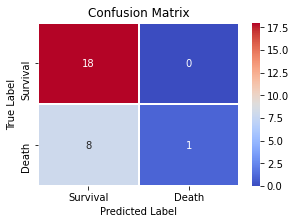

              precision    recall  f1-score   support

           0       0.69      1.00      0.82        18
           1       1.00      0.11      0.20         9

    accuracy                           0.70        27
   macro avg       0.85      0.56      0.51        27
weighted avg       0.79      0.70      0.61        27



'{"PATIENT_ID": {"0": 1, "1": 2, "2": 3, "3": 4, "4": 5, "5": 6, "6": 7, "7": 8, "8": 9, "9": 10, "10": 11, "11": 12, "12": 13, "13": 14, "14": 15, "15": 16, "16": 17, "17": 18, "18": 19, "19": 20, "20": 21, "21": 22, "22": 23, "23": 24, "24": 25, "25": 26, "26": 27}, "predicted": {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "11": 0, "12": 0, "13": 0, "14": 0, "15": 0, "16": 0, "17": 0, "18": 0, "19": 0, "20": 0, "21": 1, "22": 0, "23": 0, "24": 0, "25": 0, "26": 0}}'

In [131]:



# Our own data preprocessing function




# Make the magic here
single_tree()
